In [1]:
!pip install --upgrade pip setuptools
!pip install matplotlib tensorflow keras pandas seaborn scikit-learn imbalanced-learn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from keras import backend as K
from keras import callbacks

In [5]:
folds = pd.read_csv("/Users/renitalewis/Downloads/archive/Folds.csv")
df = pd.DataFrame(folds.iloc[:7909])
df["label"] = df["filename"].apply(lambda x: x.split("/")[3])
df['label'] = df['label'].str.strip()

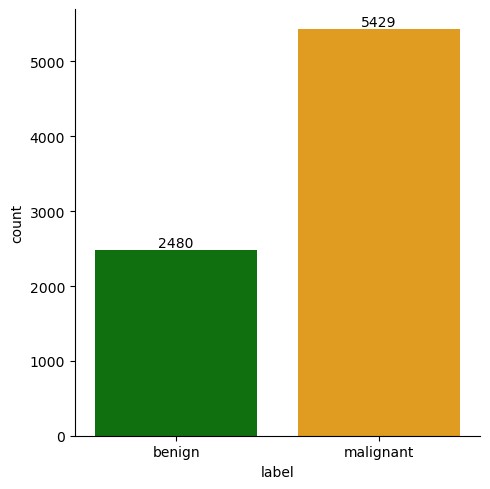

In [7]:
g = sns.catplot(x="label", data=df, kind="count", hue="label", palette=['green', 'orange'], legend=False)
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)
plt.show()

In [11]:
df['label_int'] = df.label.apply(lambda x: ['benign', 'malignant'].index(x))
X_train, X_test, y_train, y_test = train_test_split(df["filename"], df["label_int"], test_size=0.2, random_state=42)

In [13]:
train_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_test, y_test))

In [15]:
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [64, 64]) / 255.0
    return img, label

In [17]:
X_trainset = train_loader.shuffle(len(X_train)).map(parse_image).map(resize_rescale).batch(64)
X_testset = test_loader.shuffle(len(X_test)).map(parse_image).map(resize_rescale).batch(64)

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from keras import backend as K
from keras import callbacks

In [75]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)


In [79]:
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(256 * 8 * 8, activation='relu'),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='relu'),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model

def build_discriminator():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_model.trainable = False
    model = tf.keras.Sequential([
        layers.Input(shape=(64, 64, 3)),
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(1)
    ])
    return model


In [81]:
class WGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), -tf.ones((batch_size, 1))], axis=0)

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.d_loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = -tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.g_loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

latent_dim = 100
discriminator = build_discriminator()
generator = build_generator(latent_dim)

d_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
g_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
wgan = WGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
wgan.compile(d_optimizer=d_optimizer, g_optimizer=g_optimizer, d_loss_fn=wasserstein_loss, g_loss_fn=wasserstein_loss)


In [83]:
real_images = np.concatenate([img.numpy() for img, _ in X_trainset], axis=0)
wgan.fit(real_images, epochs=100, batch_size=64)

2024-07-10 01:19:50.925286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - d_loss: -1.3366 - g_loss: 0.9215
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - d_loss: -1.5902 - g_loss: -0.4021
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - d_loss: -1.5842 - g_loss: 0.4953
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - d_loss: -0.9125 - g_loss: -2.6464
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - d_loss: 1.2082 - g_loss: -10.7046
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - d_loss: -0.8072 - g_loss: -8.2076
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - d_loss: 0.6098 - g_loss: -12.0424
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - d_loss: -0.4192 - g_loss: -10.7818
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - d_loss: 0.8681 - g_loss: -12.3607
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - d_loss: -0.2675 - g_loss: -9.1022
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - d_loss: 0.2591 - g_loss: -8.3550
Epoch 12/100
99/99 ━━━━━━━━━━━━━

In [85]:
def generate_synthetic_images(generator, latent_dim, num_images):
    random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
    generated_images = generator(random_latent_vectors)
    return generated_images

num_synthetic_images = 2000
synthetic_images = generate_synthetic_images(generator, latent_dim, num_synthetic_images)
synthetic_labels = np.ones((num_synthetic_images,))  # Label synthetic images as the minority class
real_images, real_labels = next(iter(X_trainset.unbatch().batch(len(y_train))))
combined_images = np.concatenate([real_images, synthetic_images])
combined_labels = np.concatenate([real_labels, synthetic_labels])

In [87]:
shuffled_indices = np.random.permutation(len(combined_labels))
combined_images = combined_images[shuffled_indices]
combined_labels = combined_labels[shuffled_indices]

In [89]:
X_train_combined, X_val_combined, y_train_combined, y_val_combined = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [91]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_combined, y_train_combined, epochs=100, validation_data=(X_val_combined, y_val_combined))

Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 73s 348ms/step - accuracy: 0.7289 - loss: 0.5737 - val_accuracy: 0.8103 - val_loss: 0.3717
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 90s 429ms/step - accuracy: 0.8163 - loss: 0.3909 - val_accuracy: 0.8541 - val_loss: 0.3317
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 86s 412ms/step - accuracy: 0.8292 - loss: 0.3715 - val_accuracy: 0.8571 - val_loss: 0.3260
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 86s 413ms/step - accuracy: 0.8452 - loss: 0.3518 - val_accuracy: 0.8589 - val_loss: 0.3178
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 88s 420ms/step - accuracy: 0.8486 - loss: 0.3372 - val_accuracy: 0.8649 - val_loss: 0.3128
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 103s 495ms/step - accuracy: 0.8497 - loss: 0.3311 - val_accuracy: 0.8601 - val_loss: 0.3133
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 98s 469ms/step - accuracy: 0.8718 - loss: 0.3131 - val_accuracy: 0.8601 - val_loss: 0.3135
Epoch 8/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 94s 451ms/step - accuracy: 0.8645 

In [93]:
X_test_images = np.concatenate([img.numpy() for img, _ in X_testset], axis=0)
y_test_labels = np.array([label.numpy() for _, label in X_testset.unbatch()])

2024-07-10 13:55:43.041591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-10 13:55:45.378891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [95]:
loss, accuracy = model.evaluate(X_test_images, y_test_labels)
print(f"Test Accuracy: {accuracy}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.5781 - loss: 1.8874
Test Accuracy: 0.5884955525398254


In [97]:
y_pred = model.predict(X_test_images)
y_pred = (y_pred > 0.5).astype(int)

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 393ms/step


In [99]:
print(classification_report(y_test_labels, y_pred))
conf_mat = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:\n", conf_mat)

              precision    recall  f1-score   support

           0       0.34      0.30      0.32       510
           1       0.69      0.72      0.70      1072

    accuracy                           0.59      1582
   macro avg       0.51      0.51      0.51      1582
weighted avg       0.58      0.59      0.58      1582

Confusion Matrix:
 [[154 356]
 [295 777]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 305ms/step


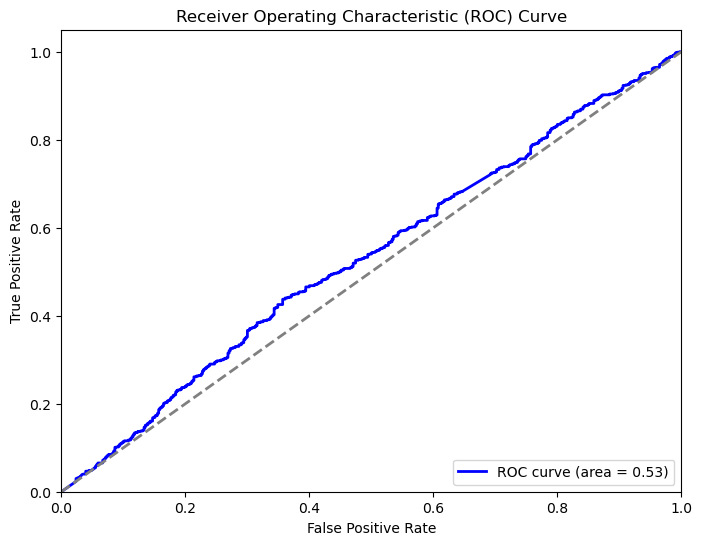

In [103]:
fpr, tpr, thresholds = roc_curve(y_test_labels, model.predict(X_test_images))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


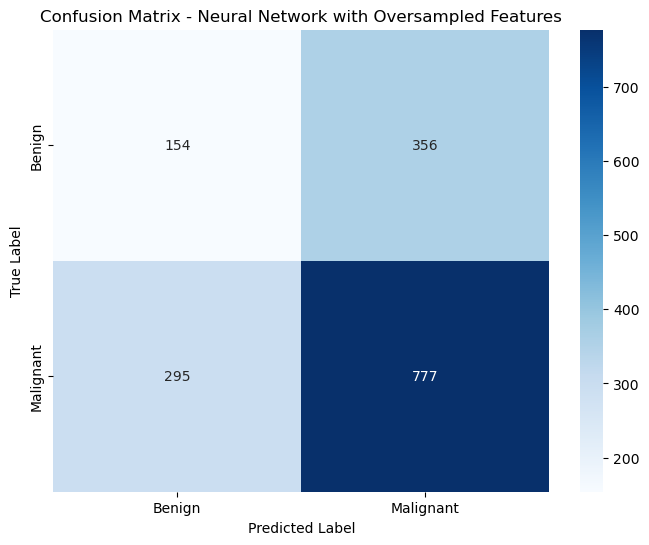

In [107]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - Neural Network with Oversampled Features')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

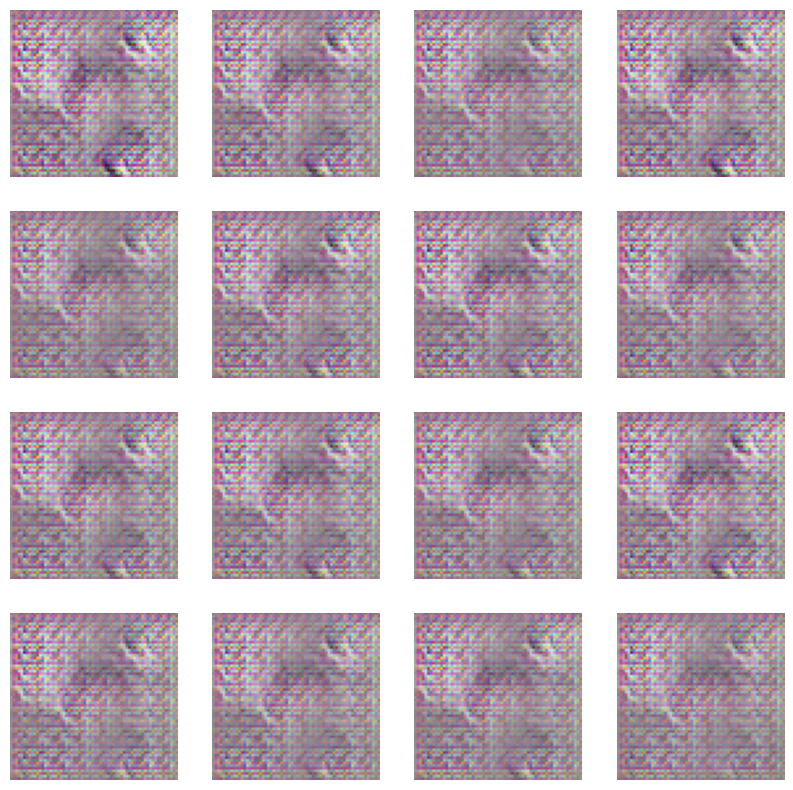

In [109]:
import matplotlib.pyplot as plt

# Visualize some of the generated images
def plot_generated_images(generator, latent_dim, n_images):
    random_latent_vectors = tf.random.normal(shape=(n_images, latent_dim))
    generated_images = generator(random_latent_vectors)
    
    plt.figure(figsize=(10, 10))
    for i in range(n_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow((generated_images[i] + 1) / 2)
        plt.axis('off')
    plt.show()

plot_generated_images(generator, latent_dim, 16)
